### IMBH Forecast

TODO:
- obscured fraction
- dust extinction/reddening effects
- 

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from astropy import units as u
import astropy.constants as const
from astropy.timeseries import LombScargle
from taufit import simulate_from_psd, smoothly_broken_power_law, fit_drw

from tqdm.notebook import tqdm

import scipy.stats as st

from astropy.cosmology import FlatLambdaCDM, z_at_value
cosmo = FlatLambdaCDM(H0=70, Om0=0.3)

import xspec
#import pyphot
from pyphot import astropy as pyphot
from labellines import labelLine, labelLines

# https://heasarc.gsfc.nasa.gov/xanadu/xspec/manual/node205.html#optxagnf
xspec.Xset.allowPrompting = False

In [2]:
from model import DemographicModel, ERDF

In [3]:
def set_mpl_style():
    
    """Function to set MPL style"""
    
    fsize = 15
    tsize = 18
    tdir = 'in'
    major = 5.0
    minor = 3.0
    lwidth = 1.8
    lhandle = 2.0
    plt.style.use('default')
    plt.rcParams['text.usetex'] = False
    plt.rcParams['font.size'] = fsize
    plt.rcParams['legend.fontsize'] = tsize
    plt.rcParams['xtick.direction'] = tdir
    plt.rcParams['ytick.direction'] = tdir
    plt.rcParams['xtick.major.size'] = major
    plt.rcParams['xtick.minor.size'] = minor
    plt.rcParams['ytick.major.size'] = 5.0
    plt.rcParams['ytick.minor.size'] = 3.0
    plt.rcParams['axes.linewidth'] = lwidth
    plt.rcParams['legend.handlelength'] = lhandle
    
    return

In [4]:
set_mpl_style()

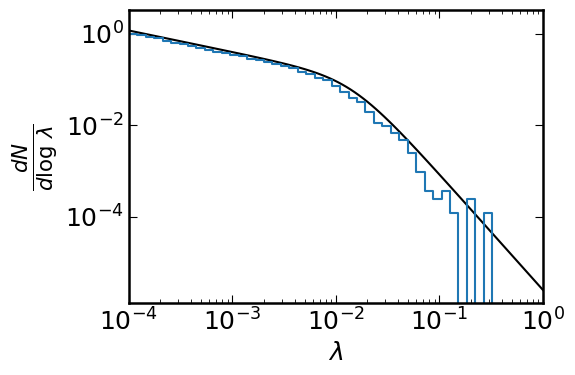

In [5]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))

l = np.logspace(-4, 0, 100)
dlogl = np.diff(np.log10(l))[0]
p = ERDF(l)*dlogl
p = p/np.sum(p)
s = np.random.choice(l, 100000, p=p)

ax.loglog(l, p/dlogl, c='k')

bins = np.logspace(-4, 0, 50)
h, bin_edges = np.histogram(s, bins=bins)
ax.step(bin_edges[:-1], h/np.diff(np.log10(bins))[0]/len(s))

ax.set_xlabel(r'$\lambda$', fontsize=18)
ax.set_ylabel(r'$\frac{dN}{d\log\ \lambda}$', fontsize=22)

ax.tick_params('both', labelsize=18)
ax.tick_params(axis='both', which='both', direction='in')
ax.tick_params(axis='both', which='major', length=6)
ax.tick_params(axis='both', which='minor', length=3)
ax.xaxis.set_ticks_position('both')
ax.yaxis.set_ticks_position('both')

ax.set_xlim(1e-4, 1e0)

fig.tight_layout()

### Load previous model instance

In [7]:
model = DemographicModel()
model.sample(nbins=10, nbootstrap=50, zmax=2.5, eta=1e7)

  0%|          | 0/50 [00:00<?, ?it/s]

In [ ]:
fig = model.plot()

In [ ]:
model.sample_sed_grid()

In [ ]:
s = model.samples
pars = model.pars

### Mock Observations: light curves

In [ ]:
num_seasons = 6
season_duration = 120 # days
cadence = 7 # days
t_obs = [np.arange(365*i, 365*i + season_duration, cadence) for i in range(num_seasons)]
t_obs = np.array(t_obs).flatten()

model.sample_light_curves(t_obs)

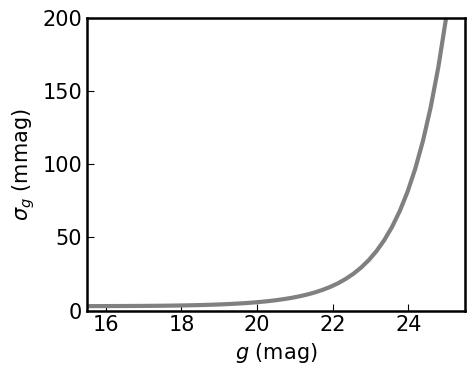

In [22]:
fig, ax = plt.subplots(1, 1, figsize=(5, 4))

m_eval = np.linspace(15, 25)

def pm_prec(mag):
    gamma = 0.038
    m_5 = 25.0
    
    sigma_sys = 0.003
    x = 10**(0.4*(mag - m_5))
    sigma_rand = np.sqrt((0.04 - gamma)*x + gamma*x**2)
    return np.sqrt(sigma_sys**2 + sigma_rand**2)

ax.plot(m_eval, 1e3*pm_prec(m_eval), color='gray', lw=3)
ax.set_xlim(15.5, 25.5)
ax.set_ylim(0, 200)
ax.set_ylabel(r'$\sigma_{g}$ (mmag)')
ax.set_xlabel(r'$g$ (mag)')

fig.tight_layout()
fig.savefig('phprec.pdf', dpi=300)

In [23]:
mask = (s[f'sigma_var'] > 3)
mag = s[f'lc_{band}'][mask][4]
plt.errorbar(t_rest, mag, yerr=pm_prec(mag))
calc_sigma_var(np.array([mag]), np.array([pm_prec(mag)]))

KeyError: 'sigma_var'

In [26]:
def calc_sigma_var(mag, magerr):
    
    N = np.shape(mag)[0] # Number of light curves
    nu = np.shape(mag)[1] - 1
    
    wt = 1/magerr**2
    m0 = np.sum(mag*wt, axis=1)/np.sum(wt, axis=1)
    m0 = np.array([m0]*(nu+1)).T # Reshape
        
    chisq = 1/nu*np.sum((mag - m0)**2*wt, axis=1)
    
    p = st.chi2.sf(chisq, nu) #1 - cdf
    
    log_p = np.log(p)
    
    sigma_var = np.zeros_like(p)
    
    mask_small = (log_p > -36)
    
    sigma_var[mask_small] = st.norm.ppf(1 - p[mask_small]/2)
    sigma_var[~mask_small] = np.sqrt(np.log(2/np.pi) - 2*np.log(8.2) - 2*log_p[~mask_small])
        
    return sigma_var

In [27]:
from tools import myvarlc, p2sigma
from statsmodels.stats.diagnostic import acorr_ljungbox


nbootstrap = pars['nbootstrap']

ndraws = 1000000
s['sigma_var'] = np.full([nbootstrap, ndraws], np.nan)
#sigma_lb = np.full([nbootstrap, ndraws], np.nan)

for j in range(pars['nbootstrap']):
    ndraw = int(s['ndraws'][j])
    mag = s[f'lc_{band}'][j,:ndraw]
    magerr = pm_prec(mag)
    s['sigma_var'][j,:ndraw] = calc_sigma_var(mag, magerr)

NameError: name 'band' is not defined

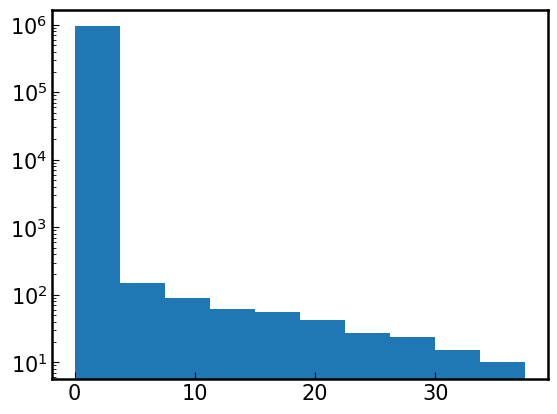

In [68]:
plt.hist(s['sigma_var'][np.isfinite(s['sigma_var'])], log=True);

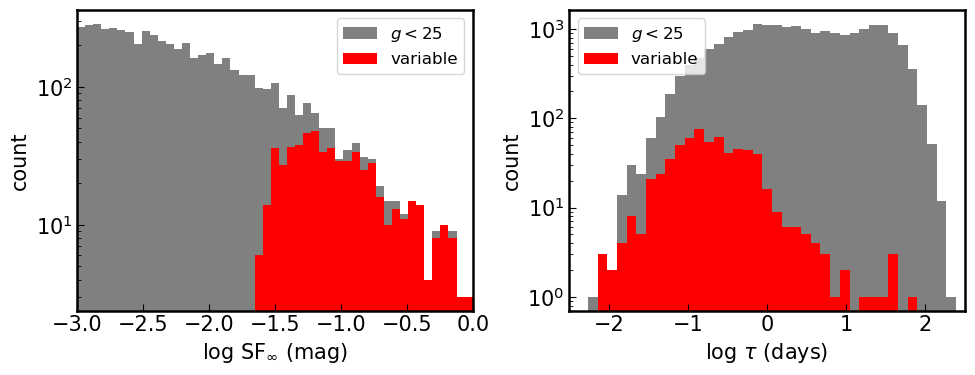

In [85]:
fig, axs = plt.subplots(1, 2, figsize=(5*2, 4))

bins = np.linspace(-3, 0)

mask_nan = np.isfinite(s[f'SFinf_{band}']) & np.isfinite(s[f'tau_{band}'])
mask_SF = s[f'SFinf_{band}'] > pm_prec(s[f'm_{band}'])
mask_tau = s[f'tau_{band}'] > 3
mask_mag = s[f'm_{band}'] < 25
mask_var = s['sigma_var'] > 3

#axs[0].hist(np.log10(s[f'SFinf_{band}'][mask_nan & mask_mag]), bins=bins, color='gray', label=r'$g<25$')
#axs[0].hist(np.log10(s[f'SFinf_{band}'][mask_nan & mask_tau & mask_SF]), bins=bins, color='r', label='variable')

axs[0].hist(np.log10(s[f'SFinf_{band}'][mask_nan & mask_mag]), bins=bins, color='gray', label=r'$g<25$', log=True)
axs[0].hist(np.log10(s[f'SFinf_{band}'][mask_nan & mask_var]), bins=bins, color='r', label='variable')

axs[0].set_xlim(-3, 0)
ax.set_ylim(0, 1500)

axs[0].set_xlabel(r'$\log\ \rm{SF}_{\infty}$ (mag)')
axs[0].set_ylabel(r'count')

axs[0].legend(fontsize=12)


bins = np.linspace(-3, 3)

#axs[1].hist(np.log10(s[f'tau_{band}'][mask_nan & mask_mag]), bins=bins, color='gray', label=r'$g<25$')
#axs[1].hist(np.log10(s[f'tau_{band}'][mask_nan & mask_tau & mask_SF]), bins=bins, color='r', label='variable')

axs[1].hist(np.log10(s[f'tau_{band}'][mask_nan & mask_mag]), bins=bins, color='gray', label=r'$g<25$', log=True)
axs[1].hist(np.log10(s[f'tau_{band}'][mask_nan & mask_var]), bins=bins, color='r', label='variable')
axs[1].set_xlim(-2.5, 2.5)

axs[1].set_xlabel(r'$\log\ \tau$ (days)')
axs[1].set_ylabel(r'count')


axs[1].legend(fontsize=12)

fig.tight_layout()
fig.savefig('var.pdf', dpi=300)

(-6.0, 2.0)

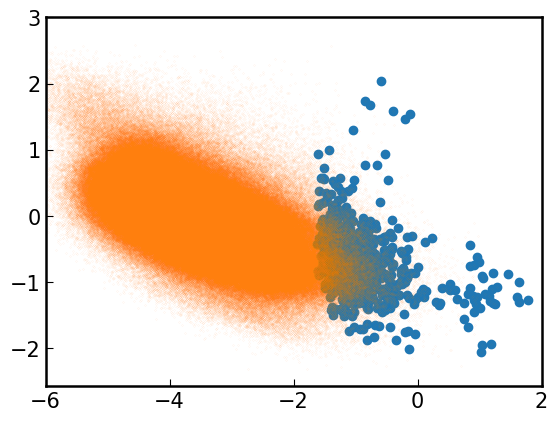

In [70]:
z = s['z_draw'][mask_nan & mask_var]
plt.scatter(np.log10(s[f'SFinf_{band}'][mask_nan & mask_var]), np.log10(s[f'tau_{band}'][mask_nan & mask_var]*(1 + z)))
z = s['z_draw'][mask_nan]
plt.scatter(np.log10(s[f'SFinf_{band}'][mask_nan]), np.log10(s[f'tau_{band}'][mask_nan]*(1 + z)), s=.001)
plt.gca().set_xlim(-6, 2)

# Why the large tau branch?

# OK, try bumping up stellar mass and BH mass to 1e13

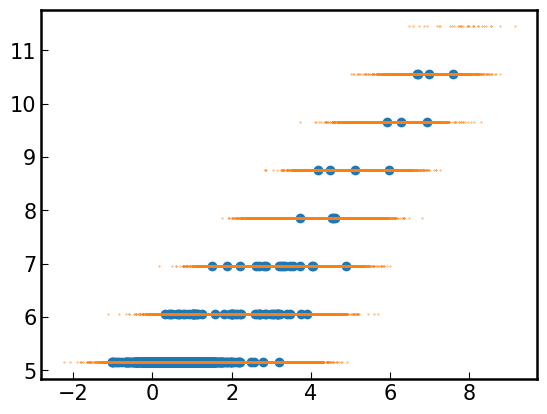

In [71]:
plt.scatter(np.log10(s[f'M_BH_draw'][mask_nan & mask_var].value), np.log10(s[f'M_star_draw'][mask_nan & mask_var].value))
plt.scatter(np.log10(s[f'M_BH_draw'][mask_nan].value), np.log10(s[f'M_star_draw'][mask_nan].value), s=.1)

In [49]:
s.keys()

dict_keys(['zmax', 'zmin', 'M_star_draw', 'n_i_M', 'z_draw', 'M_BH_draw', 'M_BH_draw_dc', 'M_BH_draw_popIII', 'n_i_M_dc', 'n_i_M_popIII', 'lambda_draw', 'n_i_Edd', 'L_draw_popIII', 'L_draw_dc', 'n_i_L_popIII', 'n_i_L_dc', 'ndraws', 'L_SDSS_g', 'M_i', 'L_SDSS_g_model', 'M_i_model', 'lc_SDSS_g', 'm_SDSS_g', 'lc_t_rest', 'SFinf_SDSS_g', 'tau_SDSS_g', 'L_host_SDSS_g'])

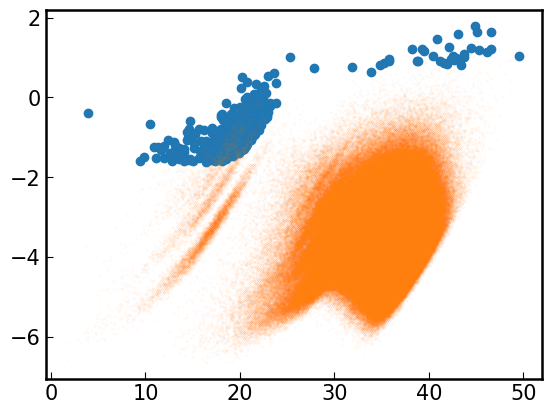

In [72]:
plt.scatter(s[f'm_{band}'][mask_nan & mask_var], np.log10(s[f'SFinf_{band}'][mask_nan & mask_var]))
plt.scatter(s[f'm_{band}'][mask_nan], np.log10(s[f'SFinf_{band}'][mask_nan]), s=.001)

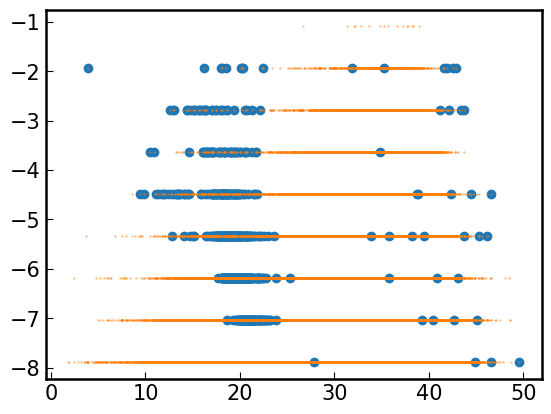

In [90]:
plt.scatter(s[f'm_{band}'][mask_nan & mask_var], np.log10(s[f'lambda_draw'][mask_nan & mask_var]))
plt.scatter(s[f'm_{band}'][mask_nan], np.log10(s[f'lambda_draw'][mask_nan]), s=.1)

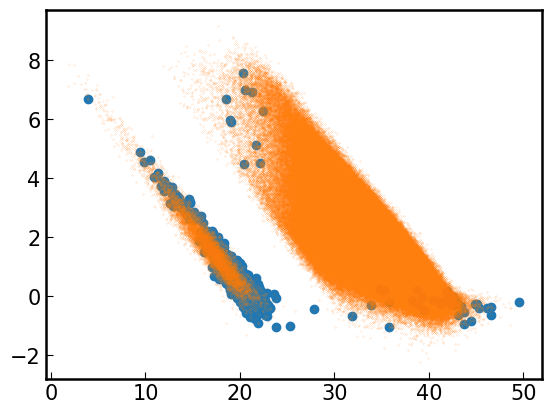

In [91]:
plt.scatter(s[f'm_{band}'][mask_nan & mask_var], np.log10(s[f'M_BH_draw'][mask_nan & mask_var].value))
plt.scatter(s[f'm_{band}'][mask_nan], np.log10(s[f'M_BH_draw'][mask_nan].value), s=.01)

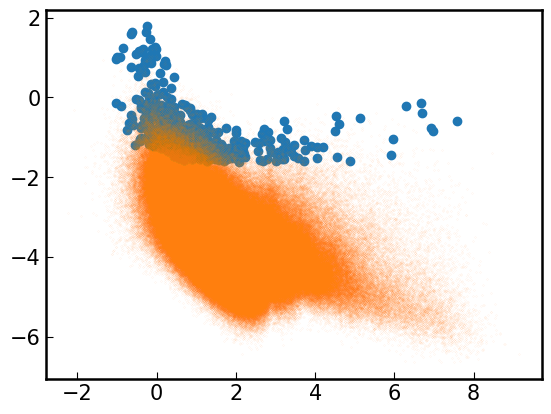

In [73]:
plt.scatter(np.log10(s[f'M_BH_draw'][mask_nan & mask_var].value), np.log10(s[f'SFinf_{band}'][mask_nan & mask_var]))
plt.scatter(np.log10(s[f'M_BH_draw'][mask_nan].value), np.log10(s[f'SFinf_{band}'][mask_nan]), s=.001)

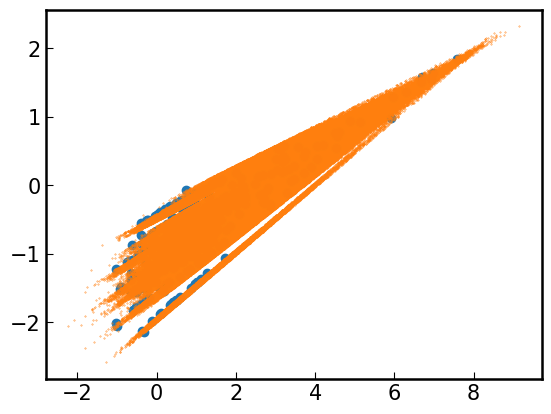

In [74]:
plt.scatter(np.log10(s[f'M_BH_draw'][mask_nan & mask_var].value), np.log10(s[f'tau_{band}'][mask_nan & mask_var]))
plt.scatter(np.log10(s[f'M_BH_draw'][mask_nan].value), np.log10(s[f'tau_{band}'][mask_nan]), s=.1)

No handles with labels found to put in legend.


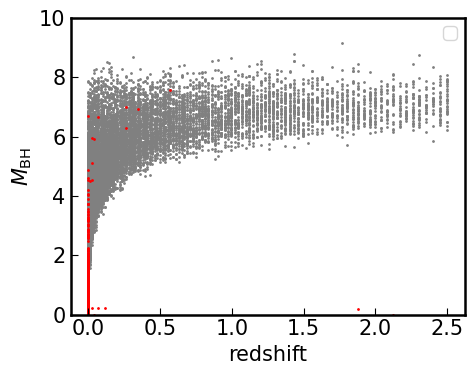

In [75]:
fig, ax = plt.subplots(1, 1, figsize=(5*1, 4))

ax.scatter(s['z_draw'][mask_mag], np.log10(s[f'M_BH_draw'].value[mask_mag]), color='gray', s=1)
ax.scatter(s['z_draw'][mask_var], np.log10(s[f'M_BH_draw'].value[mask_var]), color='r', s=1)

ax.set_ylim(0, 10)
ax.set_xlabel(r'redshift')
ax.set_ylabel(r'$M_{\rm{BH}}$')

ax.legend(fontsize=12)

fig.tight_layout()

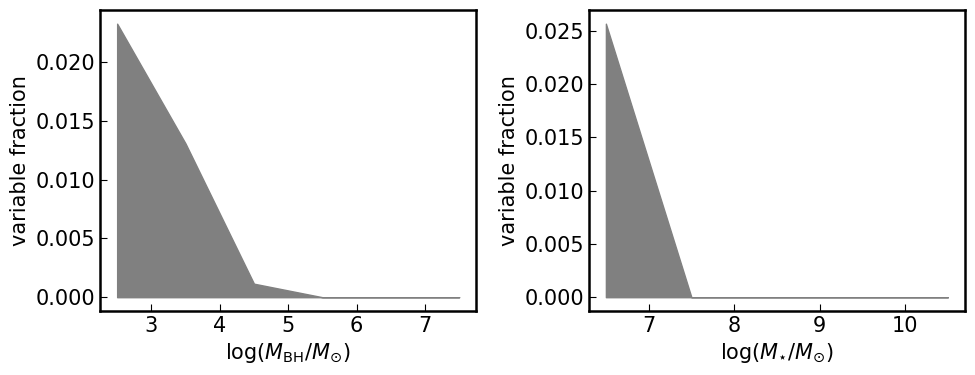

In [83]:
bins = np.arange(2, 9, 1)

nbootstrap = pars['nbootstrap']

M_BH = np.log10(s[f'M_BH_draw'].value)

f = np.full([nbootstrap, len(bins)-1], np.nan)

for j in range(nbootstrap):
    ndraw = int(s['ndraws'][j])
    mask_var = s['sigma_var'][j,:ndraw] > 3
    mask_tau = s[f'tau_{band}'][j,:ndraw] > 3
    mask_mag = s[f'm_{band}'][j,:ndraw] < 25
    bin_count, bin_edges, binnumber = st.binned_statistic(M_BH[j,:ndraw][mask_mag],
                                                          M_BH[j,:ndraw][mask_mag],
                                                          statistic='count', bins=bins)
    bin_count_var, bin_edges, binnumber = st.binned_statistic(M_BH[j,:ndraw][mask_mag & mask_var],
                                                              M_BH[j,:ndraw][mask_mag & mask_var],
                                                              statistic='count', bins=bins)
    f[j] = bin_count_var/bin_count
    
    
bin_width = (bin_edges[1] - bin_edges[0])
bin_centers = bin_edges[1:] - bin_width/2

fig, axs = plt.subplots(1, 2, figsize=(5*2, 4))
axs[0].fill_between(bin_centers, np.percentile(f, 16, axis=0), np.percentile(f, 84, axis=0), color='gray')
axs[0].set_ylabel('variable fraction')
axs[0].set_xlabel(r'$\log(M_{\rm{BH}}/M_{\odot})$')

bins = np.arange(6, 12, 1)
M_star = np.log10(s[f'M_star_draw'].value)

f = np.full([nbootstrap, len(bins)-1], np.nan)

for j in range(nbootstrap):
    ndraw = int(s['ndraws'][j])
    mask_var = s['sigma_var'][j,:ndraw] > 3
    mask_tau = s[f'tau_{band}'][j,:ndraw] > 3
    mask_mag = s[f'm_{band}'][j,:ndraw] < 25
    bin_count, bin_edges, binnumber = st.binned_statistic(M_star[j,:ndraw][mask_mag],
                                                          M_star[j,:ndraw][mask_mag],
                                                          statistic='count', bins=bins)
    bin_count_var, bin_edges, binnumber = st.binned_statistic(M_star[j,:ndraw][mask_mag & mask_var],
                                                              M_star[j,:ndraw][mask_mag & mask_var],
                                                              statistic='count', bins=bins)
    f[j] = bin_count_var/bin_count
    
bin_width = (bin_edges[1] - bin_edges[0])
bin_centers = bin_edges[1:] - bin_width/2

axs[1].fill_between(bin_centers, np.percentile(f, 16, axis=0), np.percentile(f, 84, axis=0), color='gray')
#axs[1].fill_between(bin_centers, np.median(f, axis=0))
axs[1].set_ylabel('variable fraction')
axs[1].set_xlabel(r'$\log(M_{\rm{\star}}/M_{\odot})$')

fig.tight_layout()

(array([1.46300e+03, 9.77240e+04, 6.55781e+05, 9.43861e+05, 4.96346e+05,
        1.60124e+05, 5.05490e+04, 1.82540e+04, 6.33000e+03, 4.93000e+02]),
 array([-2.19349008, -1.11252882, -0.03156757,  1.04939368,  2.13035494,
         3.21131619,  4.29227744,  5.3732387 ,  6.45419995,  7.5351612 ,
         8.61612246]),
 <BarContainer object of 10 artists>)

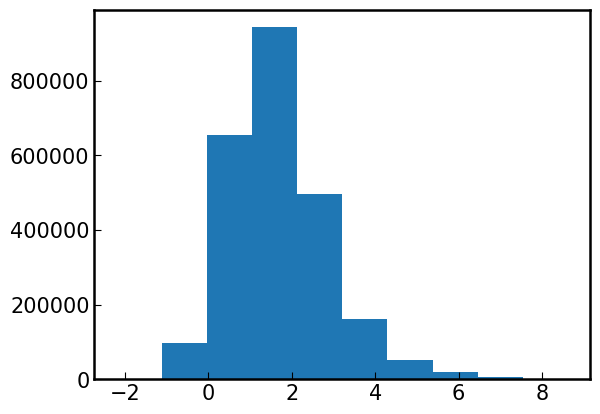

In [67]:
plt.hist(np.log10(s['M_BH_draw'].value[mask_nan]))

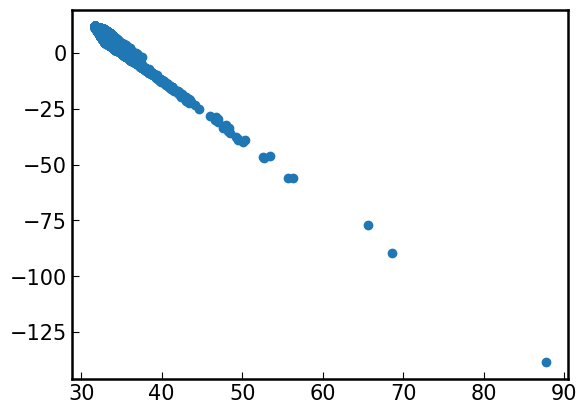

In [19]:
# M_i and L_AGN should anti-correlate very well 
plt.scatter(np.log10(s[f'L_{band}'][np.isfinite(s[f'tau_{band}'])].value),
            s[f'M_i'][np.isfinite(s[f'tau_{band}'])])

In [12]:
model = DemographicModel.load('./model.pickle') # Load previous result

### Apply flux limit

In [69]:
model.samples.keys()

dict_keys(['zmax', 'M_star_draw', 'n_i_M', 'z_draw', 'M_BH_draw', 'M_BH_draw_dc', 'M_BH_draw_popIII', 'n_i_M_dc', 'n_i_M_popIII', 'lambda_draw', 'n_i_Edd', 'L_draw_popIII', 'L_draw_dc', 'n_i_L_popIII', 'n_i_L_dc', 'ndraws', 'L_SDSS_g', 'L_{band}_model'])

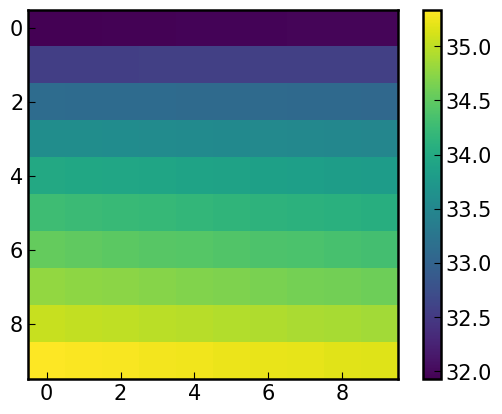

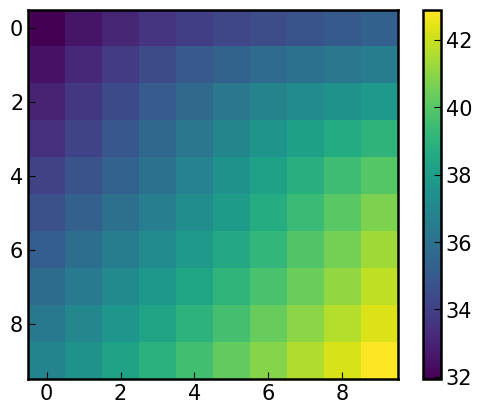

In [29]:
plt.imshow(np.log10(model.samples[f'L_{band}_model'][0,:,:].value)) # m, lambda, z
plt.colorbar()
plt.show()
plt.imshow(np.log10(model.samples[f'L_{band}_model'][:,:,0].value))
plt.colorbar()
plt.show()

### Example SEDs

In [35]:
lib = pyphot.get_library()

# if lamb_T has units the Filter object will use those.
#f = pyphot.Filter(lamb_T, T, name='my_filter', dtype='photon', unit='Angstrom') # Import Rubin filters
f = lib['SDSS_g']

0.00701593806109562
39.56530053262444 39.10037054511756
41.56530053530371 41.10037054511756
43.56530053831617 43.10037054511756
45.5653005362672 45.10037054511756


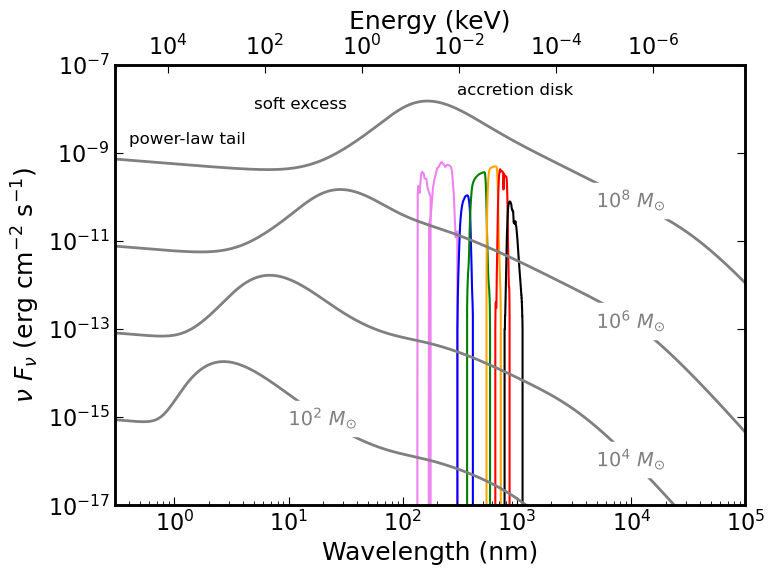

In [36]:
fig, ax = plt.subplots(1, 1, figsize=(8,6))
ax_top = ax.twiny()

d_c = 30*u.Mpc # Comoving (proper) distance

from astropy.cosmology import z_at_value
z = z_at_value(cosmo.comoving_distance, d_c)
print(z)
d_L = cosmo.luminosity_distance(z)

lambda_Edd = 0.1

# Parameters
pars = {'bh_mass':1e8,'dist_c':d_c.to(u.Mpc).value,'lambda_edd':np.log10(lambda_Edd),'spin':0,'r_cor':100,
        'log_r_out':-1,'kT_e':0.2,'tau':10,'gamma':1.8,'f_pl':0.25,'z':z,'norm':1}
bh_masses = [1e2, 1e4, 1e6, 1e8]*u.Msun

# Set energy range
e0 = (1e8*u.nm).to(u.keV, equivalencies=u.spectral())
e1 = (1e-5*u.nm).to(u.keV, equivalencies=u.spectral())
xspec.AllModels.setEnergies(f"{e0.value} {e1.value} 1000 log")
model_sed = xspec.Model("optxagnf")

for i, M_BH_i in enumerate(bh_masses):
    
    pars['bh_mass'] = M_BH_i.to(u.Msun).value
    model_sed.setPars(list(pars.values()))
    energies = model_sed.energies(0)[::-1]*u.keV # Why N-1?
    # RF -> Obs. frame
    wav = (energies[:-1]).to(u.nm, equivalencies=u.spectral())*(1 + z)
    dwav = np.diff((energies).to(u.AA, equivalencies=u.spectral())*(1 + z))
    
    # E N_E dlogE to nu f_nu
    dlogE = np.diff(np.log10(energies[::-1].value))
    sed = model_sed.values(0)[::-1]/dlogE * u.photon/u.cm**2/u.s 
    nuf_nu = sed.to(u.erg/u.cm**2/u.s, equivalencies=u.spectral_density(wav))
    
    # Make sure the bolmetric luminosities are reasonably close
    f_lambda = nuf_nu/wav
    L_lambda = (f_lambda*4*np.pi*d_L**2).to(u.erg/u.s/u.AA)
    L_bol = (lambda_Edd*1.26e38*u.erg/u.s*M_BH_i/(1*u.Msun)).to(u.erg/u.s)
    # \int f_lambda T dlambda = [erg/s/AA] [AA]
    #print(np.log10(np.trapz(L_lambda.to(u.erg/u.s/u.AA), x=wav.to(u.AA)).value))
    print(np.log10(np.sum(L_lambda*dwav).value), np.log10(L_bol.value))
    
    s = f'$10^{int(np.log10(M_BH_i.to(u.Msun).value))}$'+r'$\ M_{\odot}$'
    ax.loglog(wav.value, nuf_nu.value, color='gray', lw=2, label=s)
    ax_top.loglog(energies.value[:-1], sed, alpha=0, lw=2)
    
    
ys = 2
ax.text(3e2, 1e-8*ys, 'accretion disk', fontsize=12)
ax.text(5e0, 5e-9*ys, 'soft excess', fontsize=12)
ax.text(4e-1, 8e-10*ys, 'power-law tail', fontsize=12)

# Plot bandpasses
colors = ['violet','violet','blue','green','orange','red','black']
bands = ['GALEX_FUV','GALEX_NUV','SDSS_u','SDSS_g','SDSS_r','SDSS_i','SDSS_z']
for i, f in enumerate(bands):
    bandpass = lib[f]
        
    wav_band = (bandpass.wavelength).to(u.nm).value
    wav_band = [np.min(wav_band) - 1e-2] + list(wav_band) + [np.max(wav_band) + 1e-2]
    trans = bandpass.transmit
    trans = [0] + list(trans) + [0]
    
    ax.plot(wav_band, np.array(trans)*1e-9, color=colors[i], zorder=-10)

ax.set_ylim(1e-17, 1e-7)
ax.set_xlim(3e-1, 1e5)

#ax2.set_ylim(1e-14, 1e0)

ax_top.set_xlim(np.max(energies.value), np.min(energies.value))

ax.set_xlabel(r'Wavelength (nm)', fontsize=18)
ax.set_ylabel(r'$\nu\ F_\nu$ (erg cm$^{-2}$ s$^{-1}$)', fontsize=18)
ax_top.set_xlabel(r'Energy (keV)', fontsize=18)

lines = ax.get_lines()
labelLines(lines, zorder=2.5, fontsize=14, align=False,
           backgroundcolor='white', xvals=[2e1,1e4,1e4,1e4]*len(lines))

for ax in [ax, ax_top]:

    ax.tick_params(axis='both', which='both', direction='in', labelsize=16)
    ax.tick_params(axis='both', which='major', length=6)
    ax.tick_params(axis='both', which='minor', length=3)
    ax.yaxis.set_ticks_position('both')

fig.tight_layout()
fig.savefig('sed.pdf', dpi=300)

### Example light curves

In [ ]:
# Test host diulation
t_rest = np.arange(0, 5000, 1)
# The variable part is measured from quasars
m_var = simulate_drw(t_rest, 50, 0, 18, 0.5)
# Now add a host galaxy
m = -2.5*np.log10(10**(-0.4*16) + 10**(-0.4*m_var))
# Now what is the new SF_inft?
print(np.std(m), np.std(m_var))

plt.plot(t_rest, m)

In [ ]:
dm = 0.5
f1 = 10**(-0.4*18)
df = f1*np.log(10)/2.5*dm

f2 = 10**(-0.4*16)

dm_new = 2.5/np.log(10)*df/(f1+f2)

print(dm_new)

In [40]:
from astropy.io import ascii
dat = ascii.read('s82drw_g.dat')

tau_drw_Macleod = 10**dat['col8']*u.day
z = dat['col4']

edge = dat['col14']
Plike = dat['col15']
Pnoise = dat['col16']
Pinf = dat['col17']
Pmu = dat['col18']

#mask = (dat['col9'] != -10) #& (tau_drw_Macleod*(1+z) < 0.2*365*10*u.day)
mask = (dat['col9'] != -10) & (edge==0) & (Plike-Pnoise>2) & (Plike-Pinf>0.05) #& (tau_drw_Macleod*(1+z) < 0.2*365*10*u.day)

M_BH_Macleod = (10**dat['col6']*u.Msun)[mask]
t = tau_drw_Macleod.to(u.year).value
SF_inf_Macleod = 10**(dat['col9']*(t**0.5))[mask] # log sigma

## ZTF
dat = ascii.read('G_sigdrw_highquality.txt')
SF_inf_ZTF = np.sqrt(2)*dat['sigD']
M_BH_ZTF = 10**dat['mass']

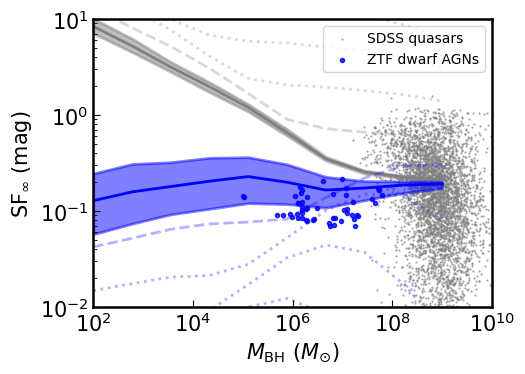

In [41]:
from model import get_AGN_flux, draw_SFinf

fig, ax = plt.subplots(1, 1, figsize=(5.5,4), sharex=True)

vget_AGN_flux = np.vectorize(get_AGN_flux)
vdraw_SFinf = np.vectorize(draw_SFinf)

size = 200
M_BH = np.logspace(2, 9, 10)*u.Msun
lambda_Edds = [0.1, 0.01, 0.001, 1e-4, 1e-5, 1e-6, 1e-7]

z_ex = 0.007 # ~30 Mpc
f_host = 0.5 #0.5 # host contaimination level

band = 'SDSS_g'
g_minus_i = 0.8 # 0.8

lambda_RF = lib[band].lpivot/(1 + z_ex)

M_i_AGNs = {}

for lambda_Edd in lambda_Edds:

    M_band_AGN, m_band_AGN, L_band_AGN, _ = vget_AGN_flux(model_sed, M_BH.value, lambda_Edd=lambda_Edd, z=z_ex, band=band)
    M_i_AGN, _, _, _ = vget_AGN_flux(model_sed, M_BH.value, lambda_Edd=lambda_Edd, z=2.0, band='SDSS_i')
    L_band_AGN = L_band_AGN*u.erg/u.s
    
    M_i_AGNs[f'{lambda_Edd}'] = M_i_AGN
    SFinf = np.empty([size, len(M_BH)])
    SFinf_host = np.empty([size, len(M_BH)])
        
    for i in range(size):
        # No host contaimination
        SFinf[i,:] = vdraw_SFinf(lambda_RF.to(u.AA).value, M_i_AGN, M_BH.value, size=1) # Delta mag

        # Use the host M/L ratio to get M_i
        #M_stellar = 1e11*u.Msun * 10**((np.log10(M_BH/(1*u.Msun) + np.random.normal(0.0, 0.5)) - 8.95)/1.40)
        if lambda_Edd == 0.1:
            # Randomize
            M_stellar = 1e11*u.Msun * 10**((np.log10(M_BH/(1*u.Msun) + np.random.normal(0.0, 0.5)) - 7.45)/1.05)
            L_band_host = f_host * M_stellar/(1*u.Msun) / 10**(2.053*g_minus_i - 1.030 + np.random.normal(0.0, 0.3))*u.Lsun
        else:
            M_stellar = 1e11*u.Msun * 10**((np.log10(M_BH/(1*u.Msun)) - 7.45)/1.05)
            L_band_host = f_host * M_stellar/(1*u.Msun) / 10**(2.053*g_minus_i - 1.030)*u.Lsun

        # Including host contaimination
        dL = L_band_AGN*np.log(10)/2.5*SFinf[i,:]
        SFinf_host[i,:] =  2.5/np.log(10)*dL/(L_band_AGN + L_band_host) # These are actually g-band

    # Plot
    if lambda_Edd == 0.1:
        ax.loglog(M_BH, np.median(SFinf, axis=0), color='gray', lw=2)
        ax.fill_between(M_BH, np.percentile(SFinf, 16, axis=0), np.percentile(SFinf, 84, axis=0),
                        color='gray', lw=2, alpha=0.5)

        ax.loglog(M_BH, np.median(SFinf_host, axis=0), color='b', lw=2)
        ax.fill_between(M_BH, np.percentile(SFinf_host, 16, axis=0), np.percentile(SFinf_host, 84, axis=0),
                        color='b', lw=2, alpha=0.5)
    elif lambda_Edd == 0.01:
        ax.loglog(M_BH, np.median(SFinf, axis=0), color='gray', lw=2, linestyle='dashed', alpha=0.3)
        ax.loglog(M_BH, np.median(SFinf_host, axis=0), color='b', lw=2, linestyle='dashed', alpha=0.3)
    else:
        ax.loglog(M_BH, np.median(SFinf, axis=0), color='grey', lw=2, linestyle='dotted', alpha=0.3)
        ax.loglog(M_BH, np.median(SFinf_host, axis=0), color='b', lw=2, linestyle='dotted', alpha=0.3)

# Data
ax.scatter(M_BH_Macleod, SF_inf_Macleod, marker='.', s=1, color='gray', alpha=0.8, label='SDSS quasars', zorder=-10)
ax.scatter(M_BH_ZTF, SF_inf_ZTF, marker='.', color='b', alpha=0.8, label='ZTF dwarf AGNs', zorder=-10)

ax.set_xlabel(r'$M_{\rm{BH}}\ (M_{\odot})$')
ax.set_ylabel(r'$\rm{SF}_{\infty}$ (mag)')
ax.set_xlim([1e2, 1e10])
ax.set_ylim([1e-2, 1e1])

ax.legend(fontsize=10, loc='upper right')
fig.tight_layout()
fig.savefig('SFinf.pdf', dpi=300)

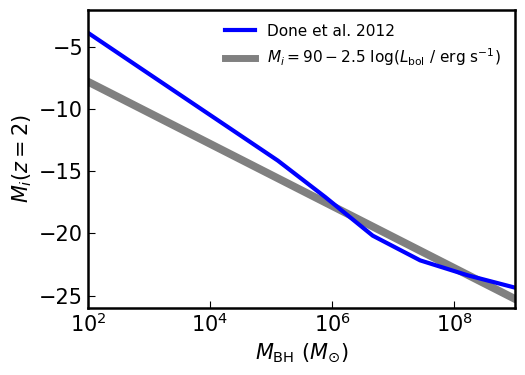

In [42]:
fig, ax = plt.subplots(1, 1, figsize=(5.5,4))

lambda_Edd = 0.1

L_bol = lambda_Edd*1.26e38*(M_BH/(1*u.Msun))*u.erg/u.s
M_i_AGN_Shen = np.array([90 - 2.5*np.log10(L_bol/(1*u.erg/u.s)) + np.random.normal(0, 0.166)
                         for i in range(size)]) # M_i(z=2) Shen
M_i_AGN = M_i_AGN + 0.5964 # assuming an alpha_nu =-0.5 contiuum spectrum

ax.plot(M_BH, M_i_AGNs[f'{lambda_Edd}'], c='b', lw=3, label='Done et al. 2012')
ax.plot([1e0], [1e0], c='gray', lw=5, label=r'$M_i = 90 - 2.5\ \log(L_{\rm{bol}}\ /\ \rm{erg}\ \rm{s}^{-1})$') # Fake line
ax.fill_between(M_BH, np.percentile(M_i_AGN_Shen, 16, axis=0), np.percentile(M_i_AGN_Shen, 84, axis=0),
                color='gray', lw=3)

ax.set_xscale('log')
ax.set_xlabel(r'$M_{\rm{BH}}\ (M_{\odot})$')
ax.set_ylabel(r'$M_i(z{=}2)$')
ax.legend(fontsize=11, frameon=False)

ax.set_xlim(1e2, 1e9)
ax.set_ylim(-26, -2)
fig.tight_layout()
fig.savefig('Mi.pdf', dpi=300)

In [55]:
from model import draw_tau, simulate_drw

def simulate_lc(t_rest, z=0.0, M_BH=1e6, lambda_Edd=0.1, band='SDSS_g', f_host=0.5,  g_minus_i=0.8, randomize=True):
    
    lambda_RF = lib[band].lpivot/(1 + z)
    
    M_band_AGN, m_band_AGN, L_band_AGN, f_band_AGN = get_AGN_flux(model_sed, M_BH, lambda_Edd=lambda_Edd, z=z, band=band)
    M_i_AGN, _, _, _ = get_AGN_flux(model_sed, M_BH, lambda_Edd=lambda_Edd, z=2.0, band='SDSS_i')
    L_band_AGN = L_band_AGN*u.erg/u.s
    
    # SF_\infy
    SFinf = draw_SFinf(lambda_RF.to(u.AA).value, M_i_AGN, M_BH, size=1, randomize=randomize)
    tau = draw_tau2(lambda_RF.to(u.AA).value, M_i_AGN, M_BH, size=1, randomize=randomize)
    
    # Use the host M/L ratio to get M_i
    if randomize:
        M_stellar = 1e11*u.Msun * 10**((np.log10(M_BH + np.random.normal(0.0, 0.5)) - 7.45)/1.05)
        L_band_host = f_host * M_stellar/(1*u.Msun) / 10**(2.053*g_minus_i - 1.030 + np.random.normal(0.0, 0.3))*u.Lsun
    else:
        M_stellar = 1e11*u.Msun * 10**((np.log10(M_BH) - 7.45)/1.05)
        L_band_host = f_host * M_stellar/(1*u.Msun) / 10**(2.053*g_minus_i - 1.030)*u.Lsun
    
    # Including host contaimination
    dL = L_band_AGN*np.log(10)/2.5*SFinf
    SFinf =  2.5/np.log(10)*dL/(L_band_AGN + L_band_host)
    
    return simulate_drw2(t_rest, tau, z, m_band_AGN, SFinf)

0.5388037554460359
0.5765200183272584
3.1004919927089185
3.317526432198542
17.84146917998777
19.09037202258691
102.6669390693498
109.85362480420424


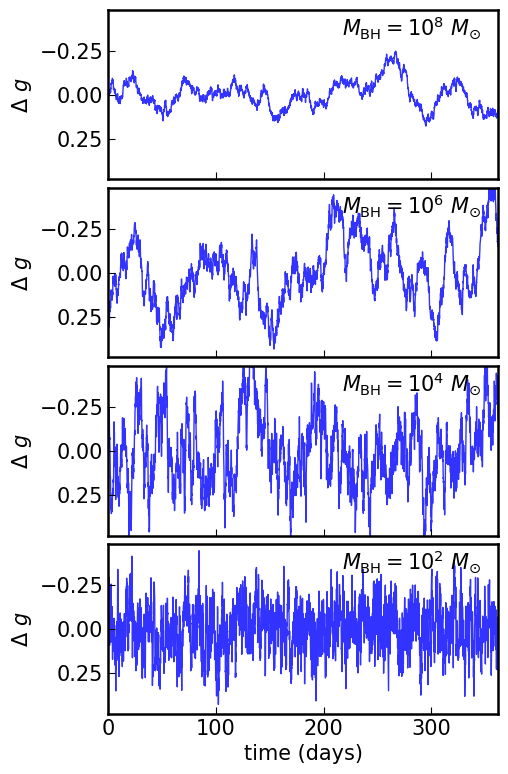

In [60]:
z_ex = 0.007 # ~30 Mpc

d_L = cosmo.luminosity_distance(z_ex).to(u.cm)
t_obs = np.arange(0, 365*1, .1)

nex = len(bh_masses)
fig, axs = plt.subplots(nex, 1, figsize=(5,2*nex), sharex=True)

M_BH = [1e2, 1e4, 1e6, 1e8]*u.Msun

for i, M_BH_i in enumerate(M_BH):
    # Get the stellar mass
    t_rest = t_obs/(1 + z_ex)
    y = simulate_lc(t_rest, z=z_ex, M_BH=M_BH_i.value, lambda_Edd=0.1, band='SDSS_g', randomize=False)
    ax = axs[len(M_BH) - 1 - i]
    y = y-np.mean(y)
    
    s = r'$M_{\rm{BH}} = '+f'10^{int(np.log10(M_BH_i.value))}$'+r'$\ M_{\odot}$'
    ax.text(0.6, 0.85, s, transform=ax.transAxes, color='k', zorder=1)
    ax.errorbar(t_rest, y, color='b', lw=1, zorder=0, alpha=0.8)
    ax.set_ylabel(r'$\Delta\ g$')
    ax.set_xlim(np.min(t_rest), np.max(t_rest))
    ax.set_ylim(np.mean(y)+0.48, np.mean(y)-0.48)

axs[-1].set_xlabel('time (days)')
fig.tight_layout()
fig.subplots_adjust(hspace=.05, left=0.2, right=0.98)
fig.savefig('lc_examples.pdf', dpi=300)

In [ ]:
#####

In [50]:
def simulate_drw2(t_rest, tau=300., z=2.0,
                       xmean=0, SFinf=0.3, random_state=None):

    N = len(t_rest)

    t_obs = t_rest * (1. + z) / tau

    x = np.zeros(N)
    x[0] = np.random.normal(xmean, SFinf)
    E = np.random.normal(0, 1, N)

    for i in range(1, N):
        dt = t_obs[i] - t_obs[i - 1]
        x[i] = (x[i - 1]
                - dt * (x[i - 1] - xmean)
                + np.sqrt(2) * SFinf * E[i] * np.sqrt(dt))

    return x

In [74]:
X_i = simulate_drw(np.arange(0, 5000, 1), xmean=20)
sig_i = np.random.normal(0, 0.1, size=len(X_i))

<ErrorbarContainer object of 3 artists>

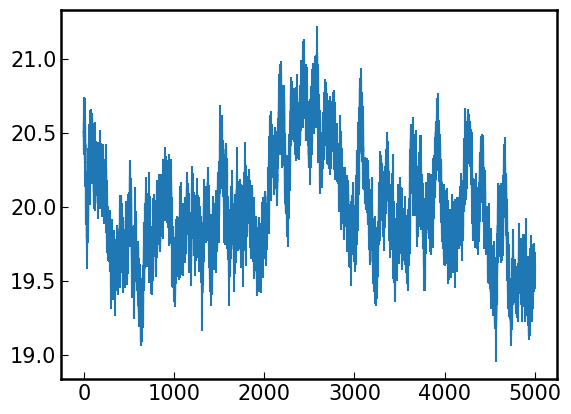

In [90]:
plt.errorbar(np.arange(0, 5000, 1), X_i, yerr=sig_i)

In [91]:
from scipy.optimize import minimize

def mle_var(x, X_i, sig_i):
    
    mu, sig_0 = x
    
    chi2 = np.sum( (X_i - mu) / (sig_0**2 + sig_i**2) ) + np.sum( np.log(sig_0**2 + sig_i**2) )

    return chi2

def var(x, X_i, sig_i):
    
    return sigma_0
    
x0 = [np.mean(X_i), np.std(X_i)]
#bounds = [(np.min(X_i), np.max(X_i)), (.01, np.std(X_i)**2 )]
res = minimize(mle_var, x0, args=(X_i, sig_i))#, bounds=bounds)
print(res.x)

#good, avg, rms, sigavg, sigrms

[ 2.04907452e+01 -1.02142007e-08]


In [85]:
bounds

[(19.15169232336819, 21.01415990668441), (-1e-05, 0.11517897191650275)]

In [71]:
np.max(X_i) - np.min(X_i)

1.64459954617109